<h1>Содержание<span class="tocSkip"></span></h1>
    
* [Краткое описание проекта](#Проект) 
* [Обзор данных](#Данные) 
* [Исследование](#Исследование) 
* [Прогноз оттока](#Отток)
* [Кластеризация](#Кластеризация)
* [Общие выводы](#Выводы)

## Краткое описание проекта <a id='Проект'></a>

**Задача**

Проанализировать данные о клиентах фитнес-центра, определить признаки пользователей, которые вероятнее всего попадут в отток и кластеризировать пользователей. После чего написать рекомендации для получившихся групп. 
    
**Описание данных:**
    
   * **gender** — пол;
   * **Near_Location** — проживание или работа в районе, где находится фитнес-центр;
   * **Partner** — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
   * **Promo_friends** — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);    
   * **Phone** — наличие контактного телефона;
   * **Age** — возраст;
   * **Lifetime** — время с момента первого обращения в фитнес-центр (в месяцах).
    
 -------
    
   * **Contract_period** — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
   * **Month_to_end_contract** — срок до окончания текущего действующего абонемента (в месяцах);
   * **Group_visits** — факт посещения групповых занятий;
   * **Avg_class_frequency_total** — средняя частота посещений в неделю за все время с начала действия абонемента;
   * **Avg_class_frequency_current_month** — средняя частота посещений в неделю за предыдущий месяц;
   * **Avg_additional_charges_total** — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
   * **Churn** — факт оттока в текущем месяце.

-----
**Стек проекта:**

Matplotlib, Pandas, Python, Scikit-learn, Seaborn.

-----
**Использованые знания навыки:**

Классификация, кластеризация, машинное обучение.

-----
**Ключевой вывод/результат проекта:** 

Мы провели обучение двух моделей для предсказания оттока пользователей, использовали _LogisticRegression_ и _RandomForestClassifier_. Оценив метрики доли правильных ответов(_Accuracy_), точности(_Rrecision_) и полноты(_Recall_) можем сказать, что модель логической регрессии показала себя лучше и стоит использовать её.

Мы провели кластеризацию пользователей, определив матрицу связей признаков и визуализировав её с помощью дендрограммы. На дендрограмме мы выдим четыре группы(четыре цвета), но одна из групп остаётся достаточно обширной и в дальнейшем пробуем разбить данные на 5 кластеров, используя _KMeans()_.
[Подробнее тут.](#Выводы) 

-----
**Статус проекта:**

Проект завершен и успешно сдан в установленые сроки. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## Обзор данных. <a id='Данные'></a>

In [2]:
path = '/datasets/gym_churn.csv'
data=pd.read_csv(path)
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
data.info()
print('Количество дубликатов в таблице:', data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
#приводим заголовки к змеиному регистру
data.columns = [x.lower() for x in data.columns]

#переведем в целочисленный формат столбец с количеством месяцев до конца абонемента:
data = data.astype({'month_to_end_contract': "Int64"})

Не все поля стоит подвергать оценке среднего, например категориальные "пол","факт посещения групповых занятий" и т.д. Поэтому ниже возьмем только часть столбцов с числовыми значениями.

In [5]:
count_data = data[['age', 
      'avg_additional_charges_total', 
      'month_to_end_contract', 
      'lifetime', 
      'avg_class_frequency_total', 
      'avg_class_frequency_current_month']]

class_data = data[['gender', 
                   'near_location', 
                   'partner', 
                   'promo_friends', 
                   'phone', 
                   'contract_period', 
                   'group_visits', 
                   'churn']]   



count_data.describe()

,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052
std,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906
min,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000
25%,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003
50%,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574
75%,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336
max,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783


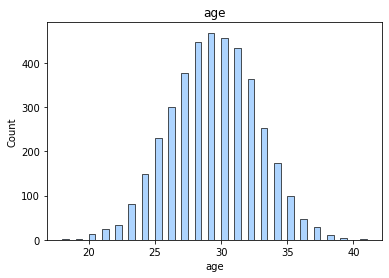

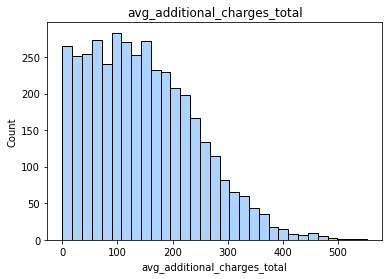

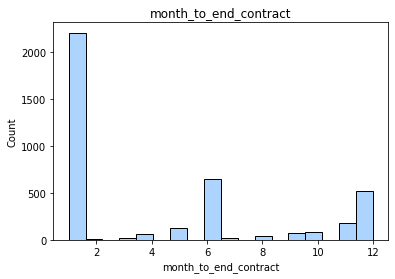

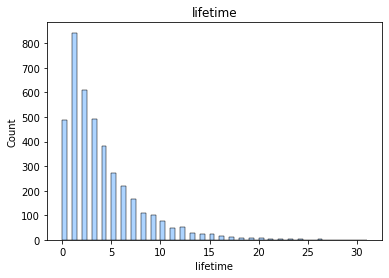

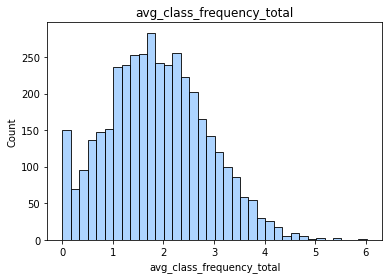

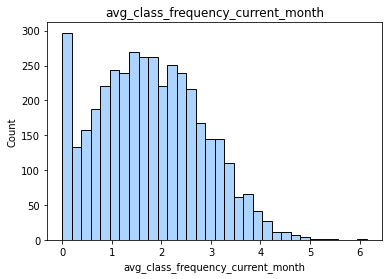

In [6]:
#проверим распределение имеющихся данных для числовых значений:
def hist_show(data):
    with plt.style.context('seaborn-pastel'):
        sns.histplot(data)
        plt.title(i) 
        plt.show()

for i in count_data.columns:
    hist_show(count_data[i])
    

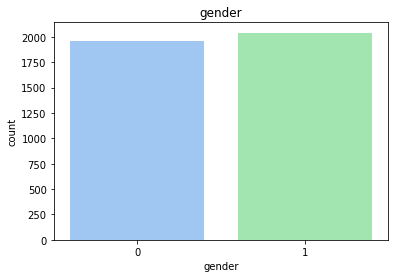

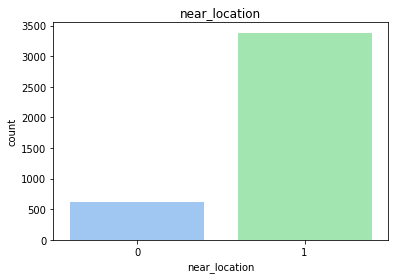

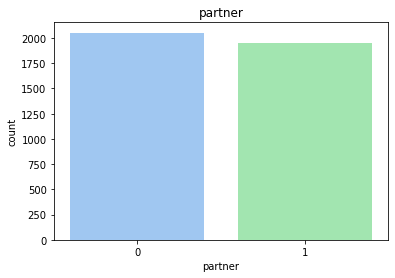

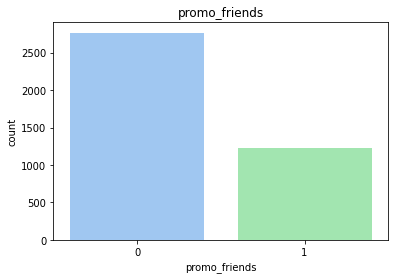

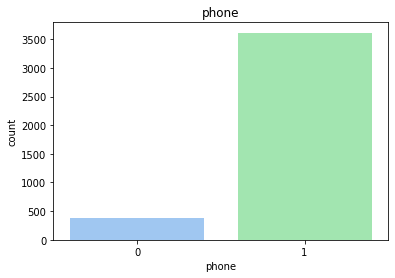

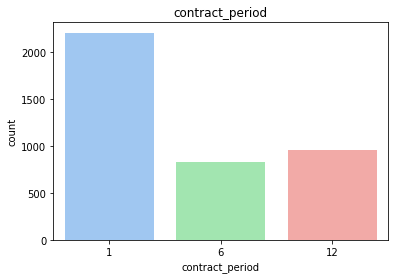

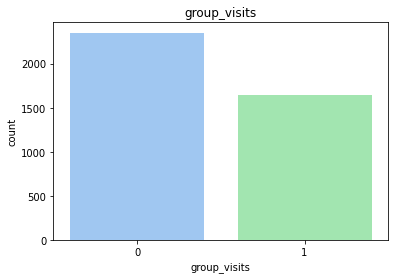

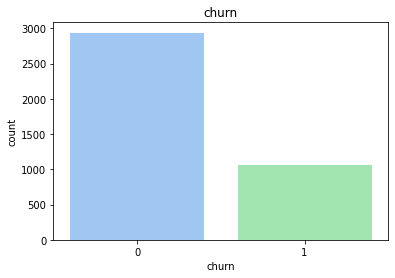

In [7]:
#проверим наличие значений во всех категориальных данных:
def plot_show(x):
    with plt.style.context('seaborn-pastel'):
        sns.countplot(x=x, data=class_data)
        plt.title(x) 
        plt.show()

for i in class_data.columns:
    plot_show(i)

**Выводы**

- нам предоставлены данные о 4000 пользователей фитнес-центра. В данных нет пропусков и явных дубликатов;
- у признаков мы видим довольно различающиеся по величине стандартные отклонения. Это говорит о том, что их стоит стандартизировать перед обучением;
- распределение числовых значений в данных выглядит нормальным, есть всплески в районе 0, но они могут быть обусловлены новыми албонементами и отвалившимися пользователями;
- в категориальных данных значения есть во всех категориях.

**Портрет среднестатистического клиента:**
29 лет, проживает или работает недалеко от клуба, недавно начал пользоваться услугами и абонемент преобретен на 1 месяц. Оставил номер телефона и скорее всего пришел без промо от партнера или друга. Приходит в фитнес дважды в неделю и скорее всего не посещает групповые занятия. 

Можно приступать к анализу. 

##  Исследование <a id='Исследование'></a>

Посмотрим на отличия и связи значений двух групп пользователей: тех, кто попадает в отток и тех, кто остался активным. 

### Сравним средние значения признаков. 

In [8]:
churn_grouped_data = data.groupby('churn').mean().reset_index()

In [9]:
churn_grouped_data

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


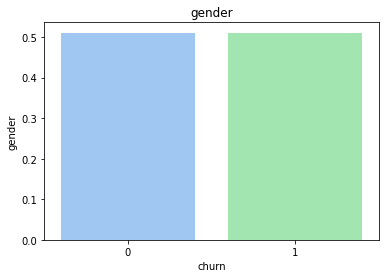

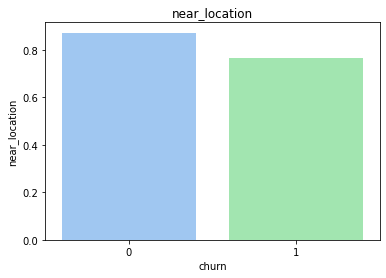

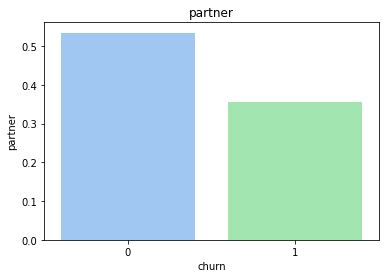

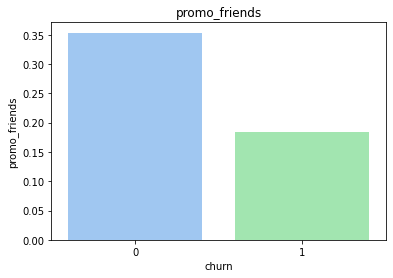

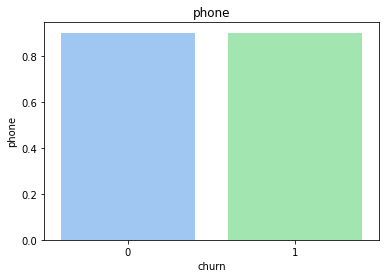

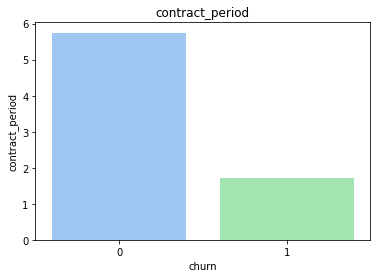

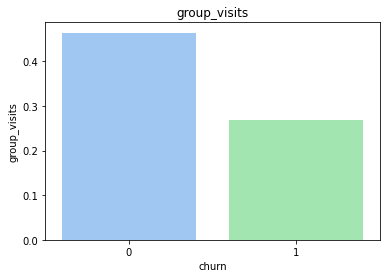

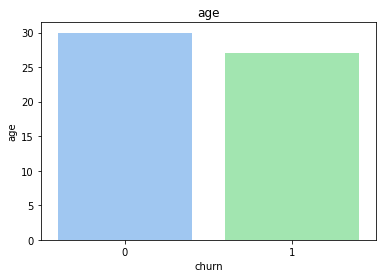

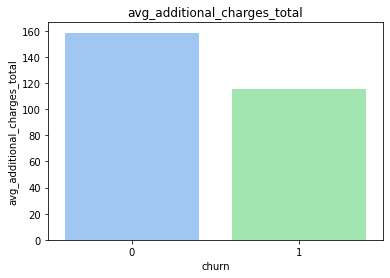

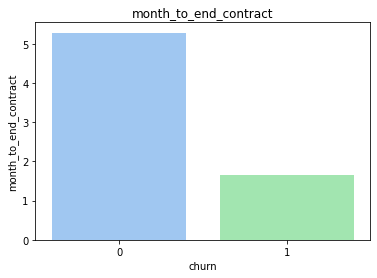

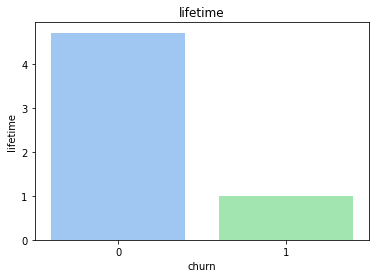

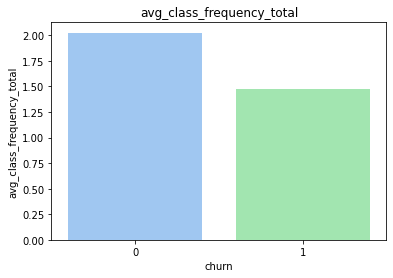

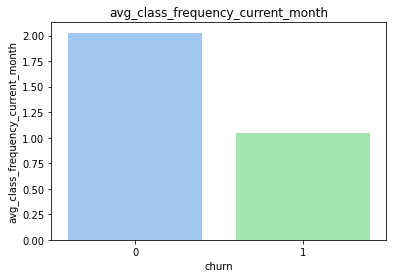

In [10]:
#визуализируем различие среднего для числовых показателей:
def barplot_show(y):
    with plt.style.context('seaborn-pastel'):
        sns.barplot(x = 'churn', y=y, data = churn_grouped_data)
        plt.title(y) 
        plt.show()
    
for i in data.drop('churn', axis = 1).columns:
    barplot_show(i)


**Вывод**

- меньше всего с оттоком связаны пол и наличие телефона в базе; 
- "ооточных" пользователей характеризует более короткий срок абонемента, более редкое посещение групповых занятий и отсутствие участия в программах лояльности ("приведи друга" или промо от партнерских сетей).

### Посмотрим на распределения значений признаков. 

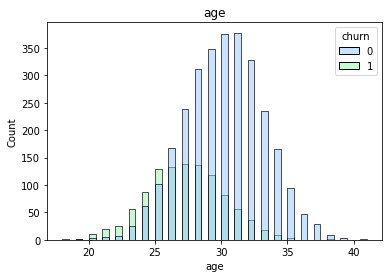

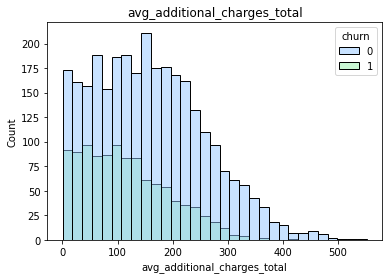

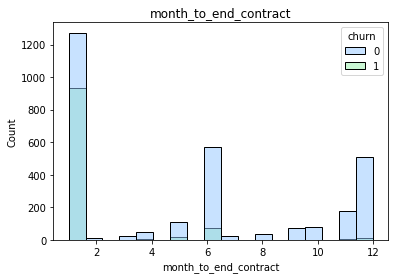

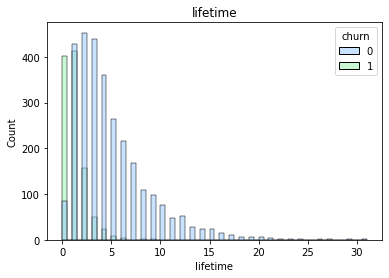

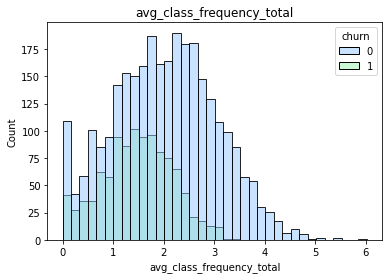

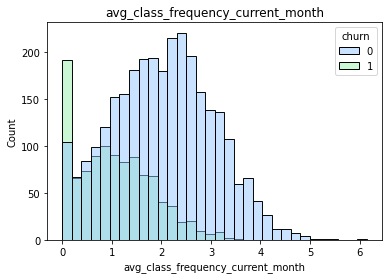

In [11]:
def show_hist_churn(x, hue):
    with plt.style.context('seaborn-pastel'):
        sns.histplot(data=data, x=x, hue=hue )
        plt.title(x) 
        plt.show()


for i in count_data.columns:
    show_hist_churn(i, 'churn')


**Выводы**

"Отточные" пользователи в среднем:
- моложе;
- меньше тратят на дополнительные услуги;
- реже посещают фитнес-центр.

## Построим и отобразим матрицу корреляций признаков.

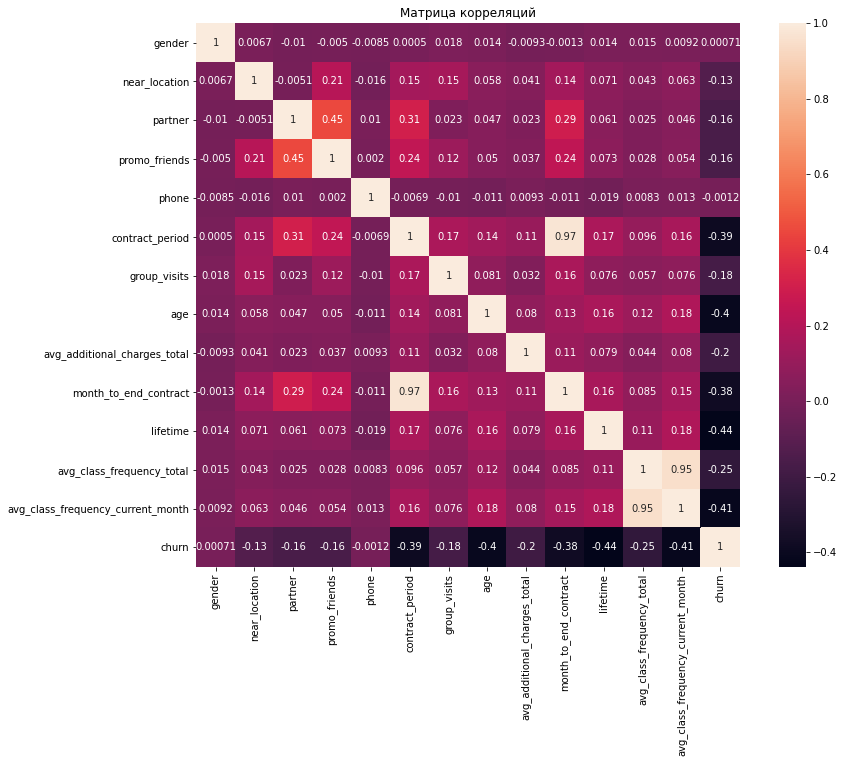

In [12]:
#построим матрицу корреляций
corr_matrix = data.corr()

#отобразим матрицу корреляций с помощью тепловой диаграммы
plt.figure(figsize=(14,10)) 
sns.heatmap(data = corr_matrix, annot=True, square=True) 
plt.title('Матрица корреляций') 
plt.show()

**Вывод**

- Практичесики все параметры имеют слабую корреляцию с оттоком; 
- Не влияют на churn: пол посететеля и наличие номера телефона в базе;
- Вероятно влияют на churn: продолжительность абонемента, возраст посетителя и его lifetime в фитнесе;
- В данных есть две пары мультиколлинеарных признаков: посещение зала в текущем месяце и вообще, а так же продолжительность контракта и время до его окончания. Стоит иметь их в виду и в случае реальной задачи подумать над избавлением от них. 


## Прогноз оттока <a id='Отток'></a>
Построим модель прогнозирования оттока клиентов

Т.к. в данных мы видили сильно разнящиеся стандартные отклонения, то перед работой с моделями стандартезируем все данные. <a id='стандарт'></a>

In [33]:
#стандартизируем датасет
scaler = StandardScaler()
X_sc = scaler.fit_transform(data)

In [34]:
#разделим наши данные на признаки и целевую переменную:
X = data.drop(columns=['churn'])
y = data['churn']

#разделяем модель на обучающую и валидационную выборку:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

В нашем случае мы имеем дело с обучением с учителем: бинарная классификация(пользователь попадает в отток или нет).
Поэтому мы можем использовать можели: LogisticRegression и RandomForestClassifier.

In [35]:
#зададим список моделей:
models = [LogisticRegression(solver='liblinear', random_state=0),RandomForestClassifier(random_state=0)]

#функция, которая принимает на вход модель и данные и выводит метрики:
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('----------------------')



In [36]:
#применим модели и посмотрим на метрики:
for i in models:
    print(i)
    make_prediction(
        i,
        X_train,
        y_train,
        X_test,
        y_test,
    )

LogisticRegression(random_state=0, solver='liblinear')
Accuracy: 0.93
Precision: 0.89
Recall: 0.83
----------------------
RandomForestClassifier(random_state=0)
Accuracy: 0.92
Precision: 0.86
Recall: 0.81
----------------------


**Вывод**

Оценив метрики доли правильных ответов(Accuracy), точности(Rrecision) и полноты(Recall) можем сказать, что модель логической регрессии показала себя лучше и стоит использовать её. 

## Кластеризация <a id='Кластеризация'></a>
Кластеризируем клиентов фитнес-центра с помощью матрицы расстояний (linkage()) и нарисуем дендрограмму.

In [30]:
#обязательная стандартизация данных перед работой с алгоритмами:
scaler = StandardScaler()

#для работы дальше используем переменную X в которой удалён столбец "churn"
#стандартизируем датасет:
X_sc = scaler.fit_transform(X)

#построим матрицу связей признаков:
linked = linkage(X_sc, method = 'ward') 

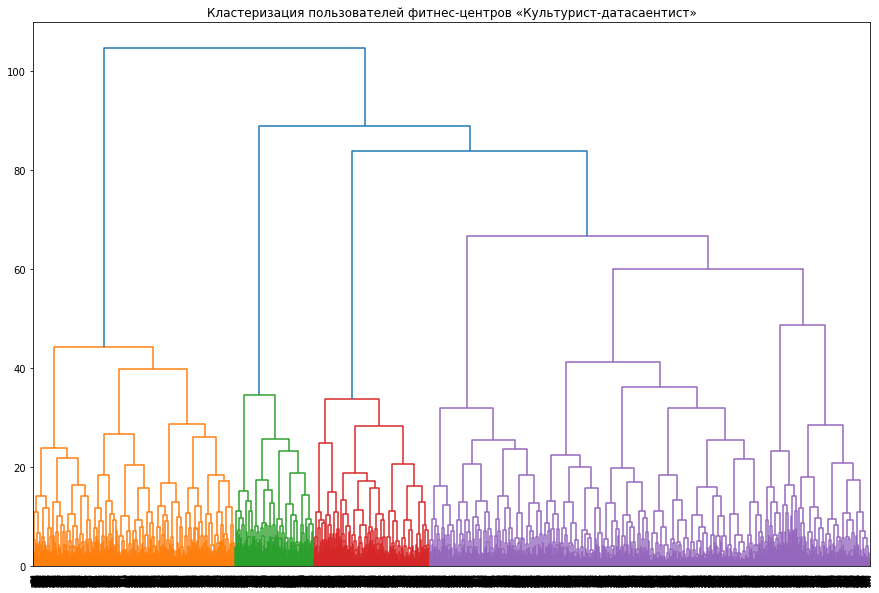

In [27]:
#отобразим матрицу связей как дендрограмму:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация пользователей фитнес-центров «Культурист-датасаентист»')
plt.show() 

Мы получили дендрограмму с 4 группами. Но одна из них значительно выбивается по размеру. Попробуем разбить пользователей на 5 групп, и проверим, что признаки для всех 5 групп достаточно различаются. 

In [31]:
#задаём модель k_means:
km = KMeans(n_clusters=5, random_state=0)

#прогнозируем кластеры для наблюдений:
clusters = km.fit_predict(X_sc)

#добавим id кластера в поле нашего датасета
data['cluster'] = clusters

### Посмотрим на средние значения признаков для каждого кластера

In [32]:
clusters_grouped = data.groupby(['cluster']).mean()
clusters_grouped

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.19802,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


**Выводы**

Все пять групп имеют свои характерные признаки и будем считать, что кластеризация на 5 групп прошла успешно.

0 группу характеризуют:
- самая высокая доля посетителей, которые пришли по промо от партнеров или друзей;
- самая большая средняя продолжительность абонемента. Вероятно, в этой группе чаще встречается 12-месячный контракт;
- самая высокая доля посетителей групповых занятий;
- самый низкий отток.

1 группу характеризуют:
- отсутствие номера телефона в базе;
- средняя(относительно других групп) продолжительность абонемента. Вероятно, в этой группе чаще встречается 6-месячный контракт;
- невысокий отток. 

2 группу характеризуют:
- недобное расположение фитнеса для посетителей (не у дома и не у работы);
- самая низкая доля участников промо от друзей;
- самая низкая посещаемость групповых занятий;
- один из самых высоких процентов оттока.

3 группу характеризуют:
- самая короткая продолжительность среднего абонемента;
- самый низкий средний возраст;
- самые низкие траты на сопутствующие услуги;
- самые "новые" посетители зала;
- самый высокий отток.

4 группу характеризуют: 
- самый высокий средний возраст;
- самые высокие средние траты на сопутствующие услуги;
- самые "старые" посетители фитрес-центра;
- самое высокое среднее посещение зада в неделю и в общем;
- низкий отток. 


На этом этапе можно предположить, что на Churn в негативном ключе влияет следующие параметры:
неудобная локация фитнес-центра(далеко от дома, работы), молодой возраст и "новизна" посетителя и короткая продолжительность абонемента.

### Посмотрим на распределения значений для различных кластеров

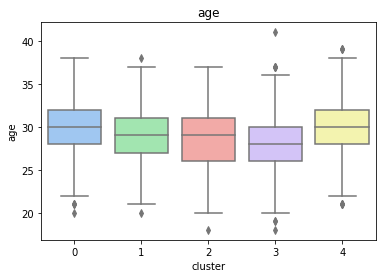

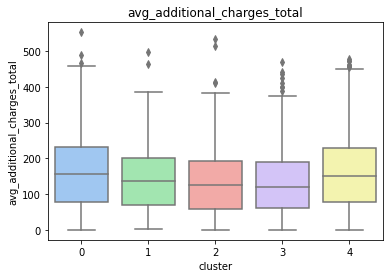

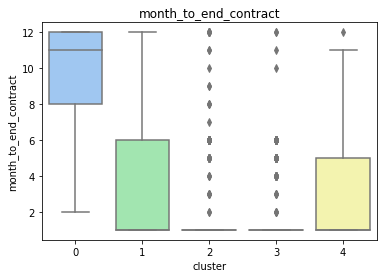

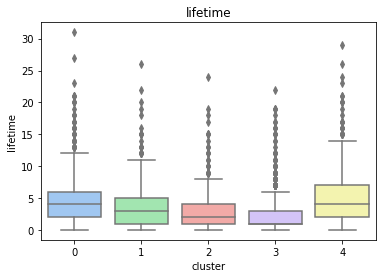

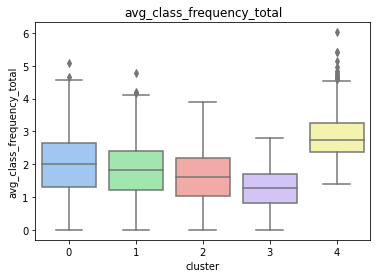

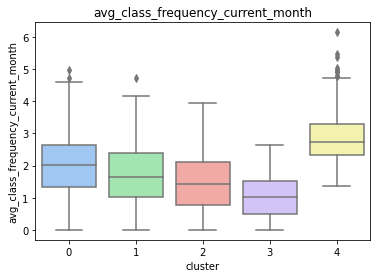

In [43]:
def show_boxplot(y):
    with plt.style.context('seaborn-pastel'):
        sns.boxplot(x='cluster', y=y, data=data)
        plt.title(y) 
        plt.show()


for i in count_data.columns:
    show_boxplot(i)

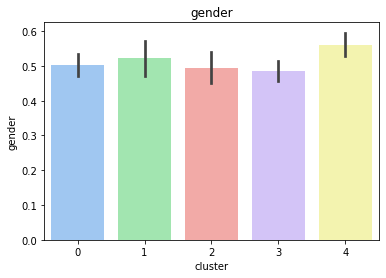

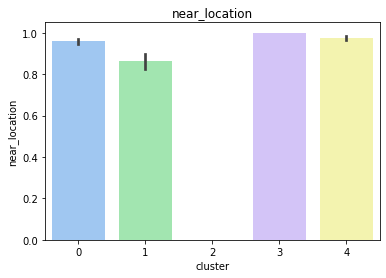

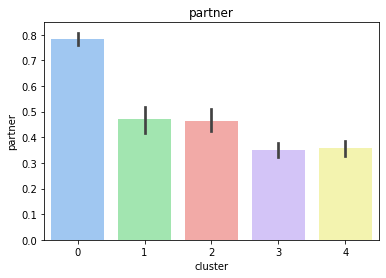

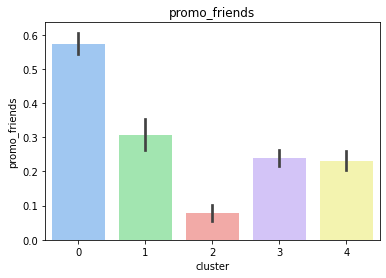

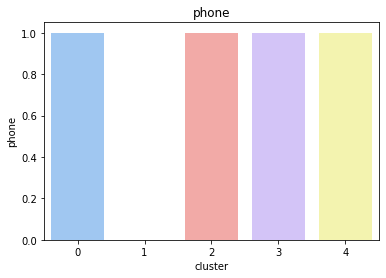

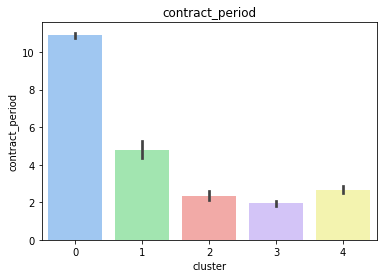

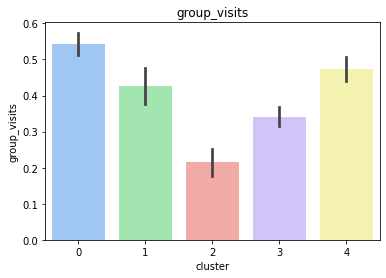

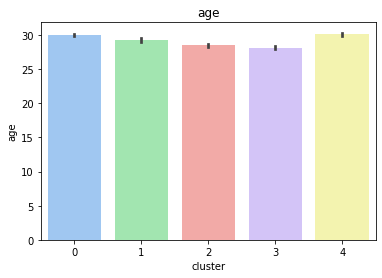

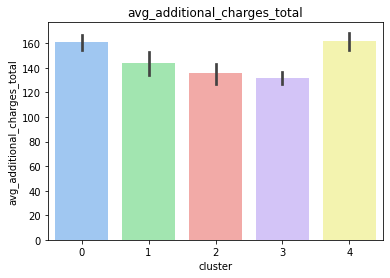

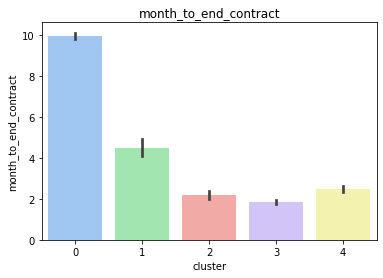

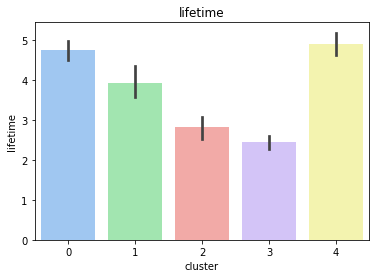

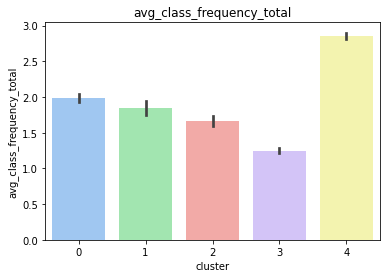

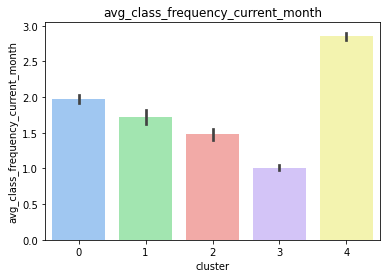

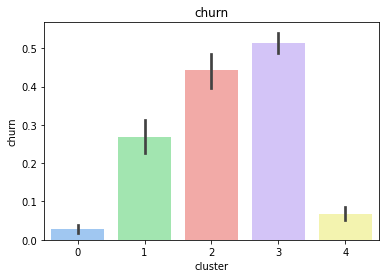

In [44]:
#визуализируем различие между кластерами для числовых показателей:
def barplot_show_cluster(y):
    with plt.style.context('seaborn-pastel'):
        sns.barplot(x = 'cluster', y=y, data=data)
        plt.title(y) 
        plt.show()
    
for i in data.drop('cluster', axis = 1).columns:
    barplot_show_cluster(i)

**Выводы**

В общем, характеристики пользователей выше подтверждаются и визуализацией. 
Группам с высоким рисктом оттока (2 и 3) так же характерно очень небольшое количество времени до окончания абонемента, но с исключениями, которые мы видим в качестве выбросов. 

### Посчитаем долю оттока по каждому кластеру

In [45]:
#посмотрим на долю оттока в каждом кластере, посчитав её через среднее значение:
cluster_grouped_data = data.groupby(['cluster'])['churn'].mean()

In [46]:
cluster_grouped_data

cluster
0    0.027723
1    0.267532
2    0.443564
3    0.514263
4    0.068019
Name: churn, dtype: float64

**Выводы**

Тут все как и показали графики и распределения выше, самые отточные группы: 3 и 2. 

Группа 1 - имеет невысокий риск оттока и на неё стоит обратить внимание, после работы с самыми "отточными" групами.

Группы 0, 4 - достаточно надежные и имеют не более 6% оттока. 

## Общие выводы <a id='Выводы'></a>


**Данные**

Нам предоставлены данные о 4000 пользователях фитнес-центра "культурист-датасайнтист". 
Данные качественные, без пропусков и дубликатов. 
Некоторые моменты, на которые стоит обратить внимание:
- Высокое стандартное отклонение признаков, в связи с которым стоит стандартизировать данные
- Наличие двух пар мультиколлинеарных признаков: 'Contract_period'&'Month_to_end_contract' и 'Avg_class_frequency_total'&'Avg_class_frequency_current_month', в данной задаче мы их оставили, но потенциально с ними можно поработать для избавления от мультиколлинеарности.
-------------------
**Предсказание оттока**

Мы провели обучение двух моделей для предсказания оттока пользователей, использовали LogisticRegression и RandomForestClassifier. Оценив метрики доли правильных ответов(Accuracy), точности(Rrecision) и полноты(Recall) можем сказать, что модель логической регрессии показала себя лучше и стоит использовать её.

-------------------
**Кластеризация пользователей**

Мы провели кластеризацию пользователей, определив матрицу связей признаков и визуализировав её с помощью дендрограммы. 
На дендрограмме мы выдим четыре группы(четыре цвета), но одна из групп остаётся достаточно обширной и в дальнейшем пробуем разбить данные на 5 кластеров, используя KMeans(). 

Мы получили 5 групп, из которых две представляют высокий риск оттока: посетители которым неудобно посещать данный фитнес-центр географически и совсем новые клиенты фитнес-центра с короткими абонементами. А так же две надёжные группы: уверенные спортсмены с годовыми абонементами и опытные, старые клиенты, которые годами посещают этот зал. 

Есть еще промежуточная группа посетителей, которую характеризует отсутствие номера телефона в базе. У нее не самый высокий отток, но с ней так же стоит поработать в будущем. 

Для того, чтоб сократить отток пользователей фитнес-центра стоит обратить внимание на:
- **Новых посетителей с непродолжительными абонементами.**
Это новые пользователи, стоит подробнее подумать о том, как вовлечь новичков в регулярный спорт и помочь им на этом этапе. Так же можно стимулировать покупку более продолжительных абонементов, возможно потраченые деньги на годовой абонемент лучше замотивируют новичка. А короткие абонементы охотнее продавать старым и лояльным пользователям фитнеса. 

- **Посетителей, которым не удобно и далеко приходить в ваш центр.**
Может быть стоит исследовать район, в которых работают/живут эти посетители и расссмотреть вариант открытия там нового зала или заключения партнерства с уже имеющимся? 